# Preprocessing

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import re
import random
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV, Ridge, RidgeCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, TransformedTargetRegressor

In [2]:
# from `input.ipynb`

from dataclasses import dataclass

import numpy as np
import pandas as pd

# Helper class
@dataclass
class Note:
    note: int = 0       # The pitch
    octave: int = 0     # The (Midi) octave
    rest: int = 0       # Whether the note is a rest
    duration: int = 0   # The duration of the note (in 1/16 second intervals)

# Options for creating the dataframe. VOICE = which voice to pick, LAG = how many periods to lag for.
VOICE = 3
LAG = 10

# Import the csv
piano_input = pd.read_csv('F.txt', sep='\t', header=None)

# Transform piano key pitch (A0 = 1) to Midi pitch (A0 = 21)
# Different sources say different numbers for A0. Might be 9 or 21. :| 9 seems to be A(-1) generally though.
# If we map octave -1 to index 0 (which is the easiest probably), then we need A0 = 21.
midi_input = piano_input.where(piano_input == 0, piano_input + 20)
# Take the voice we are working on
voice_input = midi_input.iloc[:, VOICE]

# Create an output dataframe
notes = []
# Process the first note
cur = Note(voice_input[0] % 12, voice_input[0] // 12, 1 if voice_input[0] == 0 else 0, 1)

# Process the rest of the notes
for entry in voice_input[1:]:
    note = entry % 12
    octv = entry // 12
    if cur.note == note and cur.octave == octv:
        cur.duration += 1
    else:
        notes.append(cur)
        cur = Note(note, octv, 1 if note == 0 and octv == 0 else 0, 1)

notes.append(cur)
cur = Note(note, octv, 1 if note == 0 and octv == 0 else 0, 1)

# Pandas can automatically convert a list of dataclass objects to dataframes!
notes_df = pd.DataFrame(notes)

# Create a lagged input dataframe
notes_lagged_df = notes_df.copy()

for lag in range(1, LAG + 1):
    lagged = notes_df.shift(lag)
    lagged.columns = [f'{col_name}_lag{lag}' for col_name in notes_df.columns]
    notes_lagged_df = pd.concat((notes_lagged_df, lagged), axis=1)

# Drop rows containing NA (i.e. the first LAG rows basically)
dfV1_full = notes_lagged_df
notes_lagged_df = notes_lagged_df.dropna()

# Show first 10 notes
notes_lagged_df.head(10)

,note,octave,rest,duration,note_lag1,octave_lag1,rest_lag1,duration_lag1,note_lag2,octave_lag2,...,rest_lag8,duration_lag8,note_lag9,octave_lag9,rest_lag9,duration_lag9,note_lag10,octave_lag10,rest_lag10,duration_lag10
10,4,5,0,8,11.0,4.0,0.0,4.0,5.0,5.0,...,0.0,12.0,2.0,5.0,0.0,8.0,0.0,0.0,1.0,8.0
11,9,4,0,4,4.0,5.0,0.0,8.0,11.0,4.0,...,0.0,4.0,9.0,5.0,0.0,12.0,2.0,5.0,0.0,8.0
12,4,5,0,4,9.0,4.0,0.0,4.0,4.0,5.0,...,0.0,16.0,7.0,5.0,0.0,4.0,9.0,5.0,0.0,12.0
13,9,5,0,4,4.0,5.0,0.0,4.0,9.0,4.0,...,0.0,16.0,5.0,5.0,0.0,16.0,7.0,5.0,0.0,4.0
14,7,5,0,4,9.0,5.0,0.0,4.0,4.0,5.0,...,0.0,16.0,7.0,5.0,0.0,16.0,5.0,5.0,0.0,16.0
15,5,5,0,4,7.0,5.0,0.0,4.0,9.0,5.0,...,0.0,8.0,9.0,5.0,0.0,16.0,7.0,5.0,0.0,16.0
16,2,5,0,4,5.0,5.0,0.0,4.0,7.0,5.0,...,0.0,12.0,2.0,5.0,0.0,8.0,9.0,5.0,0.0,16.0
17,10,5,0,4,2.0,5.0,0.0,4.0,5.0,5.0,...,0.0,4.0,5.0,5.0,0.0,12.0,2.0,5.0,0.0,8.0
18,9,5,0,4,10.0,5.0,0.0,4.0,2.0,5.0,...,0.0,8.0,11.0,4.0,0.0,4.0,5.0,5.0,0.0,12.0
19,7,5,0,4,9.0,5.0,0.0,4.0,10.0,5.0,...,0.0,4.0,4.0,5.0,0.0,8.0,11.0,4.0,0.0,4.0


# Models

In [3]:
dfV1_full

,note,octave,rest,duration,note_lag1,octave_lag1,rest_lag1,duration_lag1,note_lag2,octave_lag2,...,rest_lag8,duration_lag8,note_lag9,octave_lag9,rest_lag9,duration_lag9,note_lag10,octave_lag10,rest_lag10,duration_lag10
0,0,0,1,8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,5,0,8,0.0,0.0,1.0,8.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9,5,0,12,2.0,5.0,0.0,8.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7,5,0,4,9.0,5.0,0.0,12.0,2.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,5,0,16,7.0,5.0,0.0,4.0,9.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,5,5,0,16,7.0,5.0,0.0,4.0,9.0,5.0,...,0.0,4.0,0.0,5.0,0.0,2.0,2.0,5.0,0.0,2.0
659,7,5,0,16,5.0,5.0,0.0,16.0,7.0,5.0,...,0.0,4.0,10.0,4.0,0.0,4.0,0.0,5.0,0.0,2.0
660,9,5,0,16,7.0,5.0,0.0,16.0,5.0,5.0,...,0.0,8.0,9.0,4.0,0.0,4.0,10.0,4.0,0.0,4.0
661,2,5,0,4,9.0,5.0,0.0,16.0,7.0,5.0,...,0.0,4.0,10.0,4.0,0.0,8.0,9.0,4.0,0.0,4.0


Change here: duration also as categorical

In [4]:
dfV1 = notes_lagged_df
# columns as categories or contineous variables
cate_cols = [i for i in dfV1.columns.values if (re.search('note', i) or re.search('rest', i) or re.search('duration', i))]
cont_cols = [i for i in dfV1.columns.values if (re.search('octave', i))]
print(cate_cols)
print(cont_cols)

['note', 'rest', 'duration', 'note_lag1', 'rest_lag1', 'duration_lag1', 'note_lag2', 'rest_lag2', 'duration_lag2', 'note_lag3', 'rest_lag3', 'duration_lag3', 'note_lag4', 'rest_lag4', 'duration_lag4', 'note_lag5', 'rest_lag5', 'duration_lag5', 'note_lag6', 'rest_lag6', 'duration_lag6', 'note_lag7', 'rest_lag7', 'duration_lag7', 'note_lag8', 'rest_lag8', 'duration_lag8', 'note_lag9', 'rest_lag9', 'duration_lag9', 'note_lag10', 'rest_lag10', 'duration_lag10']
['octave', 'octave_lag1', 'octave_lag2', 'octave_lag3', 'octave_lag4', 'octave_lag5', 'octave_lag6', 'octave_lag7', 'octave_lag8', 'octave_lag9', 'octave_lag10']


## model for `rest`

In [5]:
rcv_pipe_rest = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown = 'ignore'), [i for i in cate_cols if (i != 'rest' and i != 'note' and i != 'duration')])
    ),
    RidgeClassifierCV(alphas = [0.001, 0.01, 0.1, 1., 10., 100., 1000.], cv = 10)
)
rcv_pipe_rest.fit(X = dfV1[dfV1.columns.drop(['rest', 'note', 'octave', 'duration'])], y = dfV1['rest'])
rcv_pipe_rest['ridgeclassifiercv'].alpha_

1.0

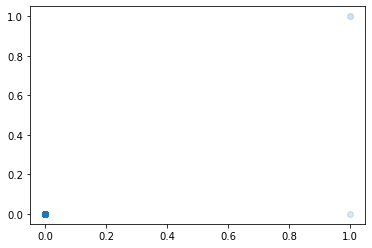

In [6]:
rcv_pipe_rest_pred = rcv_pipe_rest.predict(X = dfV1[dfV1.columns.drop(['note', 'octave', 'duration'])])
plt.scatter(dfV1.rest, rcv_pipe_rest_pred, alpha = 0.01)
# it never predicts a rest, which is fine?
# then we don't need to predict duration for rests.

## model for `octave`

In [7]:
rcv_pipe_octave = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown = 'ignore'), [i for i in cate_cols if (i != 'note' and i != 'duration')])
    ),
    RidgeClassifierCV(alphas = [0.001, 0.01, 0.1, 1., 10., 100., 1000.], cv = 10)
)
## here we need to filter out rests
rcv_pipe_octave.fit(X = dfV1[dfV1.rest != 1][dfV1.columns.drop(['note', 'octave', 'duration'])], 
                    y = dfV1[dfV1.rest != 1]['octave'])
rcv_pipe_octave['ridgeclassifiercv'].alpha_

C:\Users\jingm\.conda\envs\ml\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


1000.0

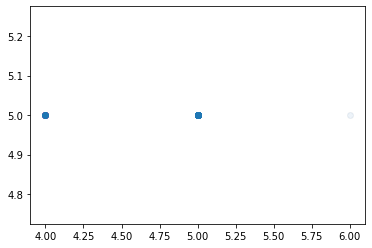

In [8]:
rcv_pipe_octave_pred = rcv_pipe_octave.predict(X = dfV1[dfV1.rest != 1][dfV1.columns.drop(['note', 'octave', 'duration'])])
plt.scatter(dfV1[dfV1.rest != 1]['octave'], rcv_pipe_octave_pred, alpha = 0.01)

## model for `note`

In [9]:
rcv_pipe_note = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown = 'ignore'), [i for i in cate_cols if (i != 'note' and i != 'duration')])
    ),
    RidgeClassifierCV(alphas = [0.001, 0.01, 0.1, 1., 10., 100., 1000.], cv = 10)
)
## here we need to filter out rests
rcv_pipe_note.fit(X = dfV1[dfV1.rest != 1][dfV1.columns.drop(['note', 'duration'])], 
                  y = dfV1[dfV1.rest != 1]['note'])
rcv_pipe_note['ridgeclassifiercv'].alpha_

C:\Users\jingm\.conda\envs\ml\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


10.0

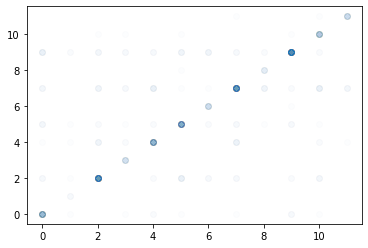

In [10]:
rcv_pipe_note_pred = rcv_pipe_note.predict(X = dfV1[dfV1.rest != 1][dfV1.columns.drop(['note', 'duration'])])
plt.scatter(dfV1[dfV1.rest != 1]['note'], rcv_pipe_note_pred, alpha = 0.01)

## model for `duration`

In [11]:
rcv_pipe_duration = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown = 'ignore'), [i for i in cate_cols if (i != 'duration')])
    ),
    RidgeClassifierCV(alphas = [0.001, 0.01, 0.1, 1., 10., 100., 1000.], cv = 10)
)
## here we need to filter out rests
rcv_pipe_duration.fit(X = dfV1[dfV1.rest != 1][dfV1.columns.drop(['duration'])], 
                    y = dfV1[dfV1.rest != 1]['duration'])
rcv_pipe_note['ridgeclassifiercv'].alpha_

C:\Users\jingm\.conda\envs\ml\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


10.0

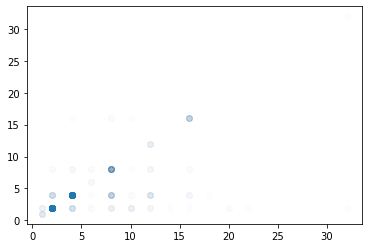

In [12]:
rcv_pipe_duration_pred = rcv_pipe_duration.predict(X = dfV1[dfV1.rest != 1][dfV1.columns.drop(['duration'])])
plt.scatter(dfV1[dfV1.rest != 1]['duration'], rcv_pipe_duration_pred, alpha = 0.01)
# this looks better.

# Prediction

In [13]:
# deterministic
dfV1_pred = dfV1_full
for i in range(100):
    # making the next row with blanks
    temp_next_row = pd.DataFrame([np.nan, np.nan, np.nan, np.nan]+dfV1_pred.tail(1).iloc[:,:-4].values.tolist()[0][:]).T
    temp_next_row.columns = dfV1_pred.columns
    dfV1_pred = dfV1_pred.append(temp_next_row, ignore_index=True)
    
    # predict the next rest (not actually predicting)
    temp_v1_rest = 0
    dfV1_pred.iloc[-1,2] = temp_v1_rest
    # predict the next octave
    temp_v1_octave = rcv_pipe_octave.predict(X=dfV1_pred.tail(1).drop(columns = ['octave', 'note', 'duration']))
    dfV1_pred.iloc[-1,1] = temp_v1_octave
    # predict the next note
    temp_v1_note = rcv_pipe_note.predict(X=dfV1_pred.tail(1).drop(columns = ['note', 'duration']))
    dfV1_pred.iloc[-1,0] = temp_v1_note
    # predict the next duration
    temp_v1_duration = rcv_pipe_duration.predict(X=dfV1_pred.tail(1).drop(columns = ['duration']))
    dfV1_pred.iloc[-1,3] = temp_v1_duration

In [14]:
# stochastic
dfV1_pred = dfV1_full
random.seed(1614)
for i in range(100):
    # making the next row with blanks
    temp_next_row = pd.DataFrame([np.nan, np.nan, np.nan, np.nan]+dfV1_pred.tail(1).iloc[:,:-4].values.tolist()[0][:]).T
    temp_next_row.columns = dfV1_pred.columns
    dfV1_pred = dfV1_pred.append(temp_next_row, ignore_index=True)
    
    # predict the next rest (not actually predicting)
    temp_v1_rest = 0
    dfV1_pred.iloc[-1,2] = temp_v1_rest
    # predict the next octave
    temp_v1_octave = rcv_pipe_octave.predict(X=dfV1_pred.tail(1).drop(columns = ['octave', 'note', 'duration']))
    dfV1_pred.iloc[-1,1] = temp_v1_octave
    # predict the next note
    # temp_v1_note = rcv_pipe_note.predict(X=dfV1_pred.tail(1).drop(columns = ['note', 'duration']))
    d = rcv_pipe_note.decision_function(X=dfV1_pred.tail(1).drop(columns = ['note', 'duration']))
    probs = [np.exp(i) / np.sum(np.exp(i)) for i in d]
    temp_v1_note = random.choices(rcv_pipe_note.classes_, weights=probs[0])[0]
    dfV1_pred.iloc[-1,0] = temp_v1_note
    # predict the next duration
    # temp_v1_duration = rcv_pipe_duration.predict(X=dfV1_pred.tail(1).drop(columns = ['duration']))
    d = rcv_pipe_duration.decision_function(X=dfV1_pred.tail(1).drop(columns = ['duration']))
    probs = [np.exp(i) / np.sum(np.exp(i)) for i in d]
    temp_v1_duration = random.choices(rcv_pipe_duration.classes_, weights=probs[0])[0]
    while(temp_v1_duration > 12):
        temp_v1_duration = random.choices(rcv_pipe_duration.classes_, weights=probs[0])[0]
    dfV1_pred.iloc[-1,3] = temp_v1_duration

In [15]:
dfV1_pred.tail(50)
# duration too long

,note,octave,rest,duration,note_lag1,octave_lag1,rest_lag1,duration_lag1,note_lag2,octave_lag2,...,rest_lag8,duration_lag8,note_lag9,octave_lag9,rest_lag9,duration_lag9,note_lag10,octave_lag10,rest_lag10,duration_lag10
713,1.0,5.0,0.0,4.0,3.0,5.0,0.0,6.0,10.0,5.0,...,0.0,10.0,4.0,5.0,0.0,4.0,3.0,5.0,0.0,4.0
714,2.0,5.0,0.0,10.0,1.0,5.0,0.0,4.0,3.0,5.0,...,0.0,2.0,11.0,5.0,0.0,10.0,4.0,5.0,0.0,4.0
715,5.0,5.0,0.0,12.0,2.0,5.0,0.0,10.0,1.0,5.0,...,0.0,6.0,7.0,5.0,0.0,2.0,11.0,5.0,0.0,10.0
716,1.0,5.0,0.0,6.0,5.0,5.0,0.0,12.0,2.0,5.0,...,0.0,4.0,1.0,5.0,0.0,6.0,7.0,5.0,0.0,2.0
717,7.0,5.0,0.0,12.0,1.0,5.0,0.0,6.0,5.0,5.0,...,0.0,4.0,2.0,5.0,0.0,4.0,1.0,5.0,0.0,6.0
718,11.0,5.0,0.0,8.0,7.0,5.0,0.0,12.0,1.0,5.0,...,0.0,4.0,8.0,5.0,0.0,4.0,2.0,5.0,0.0,4.0
719,11.0,5.0,0.0,2.0,11.0,5.0,0.0,8.0,7.0,5.0,...,0.0,2.0,1.0,5.0,0.0,4.0,8.0,5.0,0.0,4.0
720,4.0,5.0,0.0,2.0,11.0,5.0,0.0,2.0,11.0,5.0,...,0.0,6.0,10.0,5.0,0.0,2.0,1.0,5.0,0.0,4.0
721,9.0,5.0,0.0,8.0,4.0,5.0,0.0,2.0,11.0,5.0,...,0.0,4.0,3.0,5.0,0.0,6.0,10.0,5.0,0.0,2.0
722,3.0,5.0,0.0,6.0,9.0,5.0,0.0,8.0,4.0,5.0,...,0.0,10.0,1.0,5.0,0.0,4.0,3.0,5.0,0.0,6.0


In [16]:
len(dfV1_pred)
len(dfV1)

653

In [17]:
from midiutil import MIDIFile

mymidi = MIDIFile(numTracks=1)
mymidi.addTempo(track = 0, time = 0, tempo = 120)
current_time = 0
for i in range(len(dfV1_pred)):
    for j in range(1):
        current_note = int(dfV1_pred.iloc[i,0] + dfV1_pred.iloc[i,1]*12)
        if(dfV1_pred.iloc[i,2] == 1):
            current_time = current_time + int(dfV1_pred.iloc[i,3])
            continue
        mymidi.addNote(track = j, channel = 0, pitch = current_note, time = current_time*0.125, duration = int(dfV1_pred.iloc[i,3])*0.125, volume = 100)
        current_time = current_time + int(dfV1_pred.iloc[i,3])
        
with open("pred.mid", "wb") as output_file:
    mymidi.writeFile(output_file)

In [23]:
# also export the original data
from midiutil import MIDIFile

mymidi = MIDIFile(numTracks=1)
mymidi.addTempo(track = 0, time = 0, tempo = 120)
current_time = 0
for i in range(len(dfV1_full)):
    for j in range(1):
        current_note = int(dfV1_full.iloc[i,0] + dfV1_full.iloc[i,1]*12)
        if(dfV1_full.iloc[i,2] == 1):
            current_time = current_time + int(dfV1_full.iloc[i,3])
            continue
        mymidi.addNote(track = j, channel = 0, pitch = current_note, time = current_time*0.125, duration = int(dfV1_full.iloc[i,3])*0.125, volume = 100)
        current_time = current_time + int(dfV1_full.iloc[i,3])
        
with open("original.mid", "wb") as output_file:
    mymidi.writeFile(output_file)

## The same procedure, but for Little Star

In [19]:
# from `input.ipynb`

from dataclasses import dataclass

import numpy as np
import pandas as pd

# Helper class
@dataclass
class Note:
    note: int = 0       # The pitch
    octave: int = 0     # The (Midi) octave
    rest: int = 0       # Whether the note is a rest
    duration: int = 0   # The duration of the note (in 1/16 second intervals)

# Options for creating the dataframe. VOICE = which voice to pick, LAG = how many periods to lag for.
VOICE = 0
LAG = 10

# Import the csv
piano_input = pd.read_csv('twinkle.txt', sep='\t', header=None)

# Transform piano key pitch (A0 = 1) to Midi pitch (A0 = 21)
# Different sources say different numbers for A0. Might be 9 or 21. :| 9 seems to be A(-1) generally though.
# If we map octave -1 to index 0 (which is the easiest probably), then we need A0 = 21.
midi_input = piano_input.where(piano_input == 0, piano_input - 12)
# Take the voice we are working on
voice_input = midi_input.iloc[:, VOICE]

# Create an output dataframe
notes = []
# Process the first note
cur = Note(voice_input[0] % 12, voice_input[0] // 12, 1 if voice_input[0] == 0 else 0, 1)

# Process the rest of the notes
for entry in voice_input[1:]:
    note = entry % 12
    octv = entry // 12
    if cur.note == note and cur.octave == octv:
        cur.duration += 1
    else:
        notes.append(cur)
        cur = Note(note, octv, 1 if note == 0 and octv == 0 else 0, 1)

notes.append(cur)
cur = Note(note, octv, 1 if note == 0 and octv == 0 else 0, 1)

# Pandas can automatically convert a list of dataclass objects to dataframes!
notes_df = pd.DataFrame(notes)

# Create a lagged input dataframe
notes_lagged_df = notes_df.copy()

for lag in range(1, LAG + 1):
    lagged = notes_df.shift(lag)
    lagged.columns = [f'{col_name}_lag{lag}' for col_name in notes_df.columns]
    notes_lagged_df = pd.concat((notes_lagged_df, lagged), axis=1)

# Drop rows containing NA (i.e. the first LAG rows basically)
dfV1_twinkle_full = notes_lagged_df
notes_lagged_df = notes_lagged_df.dropna()

# Show first 10 notes
notes_lagged_df.head(10)

,note,octave,rest,duration,note_lag1,octave_lag1,rest_lag1,duration_lag1,note_lag2,octave_lag2,...,rest_lag8,duration_lag8,note_lag9,octave_lag9,rest_lag9,duration_lag9,note_lag10,octave_lag10,rest_lag10,duration_lag10
10,5,5,0,8,7.0,5.0,0.0,8.0,0.0,5.0,...,0.0,8.0,7.0,5.0,0.0,8.0,0.0,5.0,0.0,8.0
11,4,5,0,8,5.0,5.0,0.0,8.0,7.0,5.0,...,0.0,8.0,9.0,5.0,0.0,8.0,7.0,5.0,0.0,8.0
12,2,5,0,8,4.0,5.0,0.0,8.0,5.0,5.0,...,0.0,8.0,7.0,5.0,0.0,8.0,9.0,5.0,0.0,8.0
13,7,5,0,8,2.0,5.0,0.0,8.0,4.0,5.0,...,0.0,8.0,5.0,5.0,0.0,8.0,7.0,5.0,0.0,8.0
14,5,5,0,8,7.0,5.0,0.0,8.0,2.0,5.0,...,0.0,7.0,4.0,5.0,0.0,8.0,5.0,5.0,0.0,8.0
15,4,5,0,7,5.0,5.0,0.0,8.0,7.0,5.0,...,0.0,1.0,2.0,5.0,0.0,7.0,4.0,5.0,0.0,8.0
16,5,5,0,1,4.0,5.0,0.0,7.0,5.0,5.0,...,0.0,8.0,4.0,5.0,0.0,1.0,2.0,5.0,0.0,7.0
17,4,5,0,4,5.0,5.0,0.0,1.0,4.0,5.0,...,0.0,8.0,0.0,5.0,0.0,8.0,4.0,5.0,0.0,1.0
18,2,5,0,4,4.0,5.0,0.0,4.0,5.0,5.0,...,0.0,8.0,7.0,5.0,0.0,8.0,0.0,5.0,0.0,8.0
19,0,5,0,8,2.0,5.0,0.0,4.0,4.0,5.0,...,0.0,8.0,5.0,5.0,0.0,8.0,7.0,5.0,0.0,8.0


In [20]:
dfV1_twinkle_full.head(10)

,note,octave,rest,duration,note_lag1,octave_lag1,rest_lag1,duration_lag1,note_lag2,octave_lag2,...,rest_lag8,duration_lag8,note_lag9,octave_lag9,rest_lag9,duration_lag9,note_lag10,octave_lag10,rest_lag10,duration_lag10
0,0,5,0,8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7,5,0,8,0.0,5.0,0.0,8.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9,5,0,8,7.0,5.0,0.0,8.0,0.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7,5,0,8,9.0,5.0,0.0,8.0,7.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,5,0,8,7.0,5.0,0.0,8.0,9.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4,5,0,8,5.0,5.0,0.0,8.0,7.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2,5,0,7,4.0,5.0,0.0,8.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,4,5,0,1,2.0,5.0,0.0,7.0,4.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,5,0,8,4.0,5.0,0.0,1.0,2.0,5.0,...,0.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,7,5,0,8,0.0,5.0,0.0,8.0,4.0,5.0,...,0.0,8.0,0.0,5.0,0.0,8.0,NaN,NaN,NaN,NaN


In [21]:
# stochastic
dfV1_twinkle = dfV1_twinkle_full
random.seed(1614)
for i in range(100):
    # making the next row with blanks
    temp_next_row = pd.DataFrame([np.nan, np.nan, np.nan, np.nan]+dfV1_twinkle.tail(1).iloc[:,:-4].values.tolist()[0][:]).T
    temp_next_row.columns = dfV1_twinkle.columns
    dfV1_twinkle = dfV1_twinkle.append(temp_next_row, ignore_index=True)
    
    # predict the next rest (not actually predicting)
    temp_v1_rest = 0
    dfV1_twinkle.iloc[-1,2] = temp_v1_rest
    # predict the next octave
    temp_v1_octave = rcv_pipe_octave.predict(X=dfV1_twinkle.tail(1).drop(columns = ['octave', 'note', 'duration']))
    dfV1_twinkle.iloc[-1,1] = temp_v1_octave
    # predict the next note
    # temp_v1_note = rcv_pipe_note.predict(X=dfV1_twinkle.tail(1).drop(columns = ['note', 'duration']))
    d = rcv_pipe_note.decision_function(X=dfV1_twinkle.tail(1).drop(columns = ['note', 'duration']))
    probs = [np.exp(i) / np.sum(np.exp(i)) for i in d]
    temp_v1_note = random.choices(rcv_pipe_note.classes_, weights=probs[0])[0]
    dfV1_twinkle.iloc[-1,0] = temp_v1_note
    # predict the next duration
    # temp_v1_duration = rcv_pipe_duration.predict(X=dfV1_twinkle.tail(1).drop(columns = ['duration']))
    d = 3.5*rcv_pipe_duration.decision_function(X=dfV1_twinkle.tail(1).drop(columns = ['duration']))
    probs = [np.exp(i) / np.sum(np.exp(i)) for i in d]
    temp_v1_duration = random.choices(rcv_pipe_duration.classes_, weights=probs[0])[0]
    while(temp_v1_duration > 12):
        temp_v1_duration = random.choices(rcv_pipe_duration.classes_, weights=probs[0])[0]
    dfV1_twinkle.iloc[-1,3] = temp_v1_duration

In [22]:
from midiutil import MIDIFile

mymidi = MIDIFile(numTracks=1)
mymidi.addTempo(track = 0, time = 0, tempo = 120)
current_time = 0
for i in range(len(dfV1_twinkle)):
    for j in range(1):
        current_note = int(dfV1_twinkle.iloc[i,0] + dfV1_twinkle.iloc[i,1]*12)
        print(current_time, current_note, int(dfV1_twinkle.iloc[i,3]))
        if(dfV1_twinkle.iloc[i,2] == 1):
            current_time = current_time + int(dfV1_twinkle.iloc[i,3])
            continue
        mymidi.addNote(track = j, channel = 0, pitch = current_note, time = current_time*0.125, duration = int(dfV1_twinkle.iloc[i,3])*0.125, volume = 100)
        current_time = current_time + int(dfV1_twinkle.iloc[i,3])
        
with open("twinkle_pred.mid", "wb") as output_file:
    mymidi.writeFile(output_file)

0 60 8
8 67 8
16 69 8
24 67 8
32 65 8
40 64 8
48 62 7
55 64 1
56 60 8
64 67 8
72 65 8
80 64 8
88 62 8
96 67 8
104 65 8
112 64 7
119 65 1
120 64 4
124 62 4
128 60 8
136 67 8
144 69 8
152 67 8
160 65 8
168 64 8
176 62 7
183 64 1
184 60 8
192 62 6
198 68 2
200 69 2
202 62 2
204 71 2
206 69 2
208 67 2
210 67 2
212 65 2
214 70 2
216 71 2
218 60 2
220 66 2
222 70 2
224 71 2
226 66 2
228 70 2
230 71 2
232 67 2
234 69 2
236 69 2
238 60 2
240 63 2
242 62 2
244 63 2
246 71 2
248 60 2
250 67 2
252 65 8
260 66 2
262 65 2
264 61 4
268 61 4
272 60 4
276 62 4
280 64 4
284 70 4
288 60 8
296 63 8
304 61 4
308 70 4
312 62 4
316 67 8
324 67 8
332 69 8
340 67 8
348 65 1
349 68 4
353 61 4
357 62 4
361 64 4
365 71 4
369 66 4
373 62 4
377 62 4
381 68 4
385 61 4
389 64 8
397 69 4
401 62 4
405 60 4
409 63 4
413 65 4
417 67 4
421 64 4
425 65 4
429 64 4
433 64 4
437 61 4
441 65 4
445 63 4
449 70 10
459 61 2
461 63 2
463 64 2
465 68 2
467 69 2
469 66 2
471 65 2
473 68 2
475 69 2
477 70 2
479 69 6
485 71 2
487 71 